In [1]:
import numpy as np
import pandas as pd
import random as rd
import math
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook
from keras.utils import np_utils
import tensorflow as tf
rd.seed=0

C:\Users\Dan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Feature Extraction and Data Pre-processing

In [2]:
# Function to read n random files, given .csv file
def readNRandomLines(n, file):
    fileSize = sum(1 for line in open(file)) - 1
    if (fileSize < n):
        skip = 0
    else:
        skip = sorted(rd.sample(range(1,fileSize+1) ,fileSize-n))
    df = pd.read_csv(file, skiprows=skip)
    return df

In [3]:
# Function to generate n datasamples of writer pairs, given the raw dataset
def generateFeaturesAndLabels(dataset, n):
    datasetCopy = dataset.copy()
    
    subDict = {'f'+str(k) : [] for k in range(dataset.shape[1]-1)}
#     subDict['image1'] = []
#     subDict['image2'] = []
    subDict['target'] = []
    concatDict = {'f'+str(k) : [] for k in range((dataset.shape[1]-1)*2)}
#     concatDict['image1'] = []
#     concatDict['image2'] = []

    concatDict['target'] = []
    countDiff = 0
    countSame = 0
    
    for img1 in dataset['img_id']:
        datasetCopy.drop(datasetCopy.loc[datasetCopy['img_id'] == img1].index, inplace=True)
        imgCopy = str()
        
        for img2 in datasetCopy['img_id']:
            target = -1
            
            if img1[0:4] == img2[0:4] and img1 != img2 and countSame < n:
                target = 1
                countSame+=1
            elif img1[0:4] != img2[0:4] and imgCopy != img1 and countDiff < n:
                imgCopy = img1
                target = 0
                countDiff+=1
                
            if (target >= 0):
                data1 = dataset.loc[dataset['img_id'] == img1]
                data2 = dataset.loc[dataset['img_id'] == img2]
                dataArray1 = np.array(data1[data1.columns[1:dataset.shape[1]]].values)
                dataArray2 = np.array(data2[data2.columns[1:dataset.shape[1]]].values)
                concatData = np.concatenate((dataArray1, dataArray2), axis = 1)
                subtractData = dataArray1-dataArray2
#                 subDict['image1'].append(img1)
#                 subDict['image2'].append(img2)

                for i in range(dataset.shape[1]-1):
                    subDict['f'+str(i)].append(int(subtractData[:,i]))
                subDict['target'].append(target)
#                 concatDict['image1'].append(img1)
#                 concatDict['image2'].append(img2)

                for i in range((dataset.shape[1]-1)*2):
                    concatDict['f'+str(i)].append(int(concatData[:,i]))
                concatDict['target'].append(target)
                
            if countSame == n and countDiff == n:
                break;
        if countSame == n and countDiff == n:
             break;     
                
    return pd.DataFrame(subDict), pd.DataFrame(concatDict)

In [4]:
# Function to extract feature pairs and label them, this generates the raw data for the model
def featureExtraction():
    # Read ROWS_READ random samples from the 2 feature sets
    ROWS_READ = 10000
    GSCDataset = readNRandomLines(ROWS_READ, 'GSC-Dataset\GSC-Features-Data\GSC-Features.csv')
    HumanObservedDataset = readNRandomLines(ROWS_READ, 'HumanObserved-Dataset\HumanObserved-Features-Data\HumanObserved-Features-Data.csv')

    # Read ROWS_READ random samples from the 2 feature sets
    subDFHuman, concatDFHuman = generateFeaturesAndLabels(HumanObservedDataset, 800)
    subDFGSC, concatDFGSC = generateFeaturesAndLabels(GSCDataset, 10000)

    # Save the sample features extracted with same and different writer pairs in corresponding files
    subDFHuman.to_csv('HumanObservedSubtracted.csv')
    concatDFHuman.to_csv('HumanObservedConcatenated.csv')
    subDFGSC.to_csv('GSCSubtracted.csv')
    concatDFGSC.to_csv('GSCConcatenated.csv')
    return subDFHuman, concatDFHuman, subDFGSC, concatDFGSC

# Function to split dataset to training, validation and test sets
def dataPreprocessing(dataset):
    dataset = dataset.sample(frac=1, random_state=0)

    data = np.array(dataset[dataset.columns[0:dataset.shape[1]-1]])
    target = np.array(dataset[dataset.columns[dataset.shape[1]-1]])

    trainingTarget = GenerateTrainingData(target)
    trainingData = GenerateTrainingData(data)

    validationTarget = GenerateValTestData(target, len(trainingTarget))
    validationData = GenerateValTestData(data, len(trainingData))

    testingTarget = GenerateValTestData(target, len(trainingTarget) + len(validationTarget))
    testingData = GenerateValTestData(data, len(trainingData) + len(validationData)) 
    return trainingTarget, trainingData, validationTarget, validationData, testingTarget, testingData

# Linear Regression and Logistic Regression

In [5]:
# From the raw data read from the file, generate training target by taking the first 80% of samples
def GenerateTrainingData(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    return t


# From the raw data read from the file, generate validation input data by taking the the next 10% (after training samples) of samples
#  Here training count is also specified, so the function can select samples after the training data
def GenerateValTestData(rawData, TrainingCount, ValPercent=10): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

# Function to generate big sigma, which is a measure of how the input data spreads for each feature in the dataset
def GenerateBigSigma(Data, MuMatrix,IsSynthetic = False):
    
    #  Create empty matrix of size (f,f) where f is number of features in dataset    
    BigSigma    = np.zeros((len(Data[0]),len(Data[0])))
       
    # Ensures that variance is calculated only on 80% of input data used for training 
    TrainingLen = math.ceil(len(Data))   
    varVect     = []
    
    # Calculate variance for each of 41 features
    for i in range(0,len(Data[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[j][i])    
        varVect.append(np.var(vct))
    
    # The variances computed in the previous step are used to generate the (fxf) diagonal matrix big sigma
    for j in range(len(Data[0])):
        BigSigma[j][j] = varVect[j]
        
    # Value of big sigma multiplied with a large number to ensure its value stays significant
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

# This function does (x-mu)*(sigma^-1)(s-mu), where x is a single row from the data set and mu is one of the M cluster centroids and sigma^-1 is matrix inverse of big sigma
def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

# Function to get e^(-0.5X), where X is the scalar value returned from the GetScalar function
def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

# Function to generate the phi matrix, the matrix representation of the values of radial basis functions of the input with M centroids,
# which will be used to train the parameters in linear regression. RBFs are used to introduce non-linearity in the model.
def GetPhiMatrix(Data, MuMatrix, BigSigma):
    
           
    PHI = np.zeros((int(len(Data)),len(MuMatrix))) 
    
    # Get matrix inverse of big sigma
    BigSigInv = np.linalg.pinv(BigSigma)
    
    # Calculate value of the radial basis function for each sample in the input data set with each M centroid, for the big sigma calculated
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(len(Data))):
            PHI[R][C] = GetRadialBasisOut(Data[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

# Function to compute performance of the linear regression model for given training/validation/test predicted labels and their corresponding targets
def GetErmsLinear(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

# Function to compute performance of the logistic regression model for given training/validation/test predicted labels and their corresponding targets
def GetErmsLogistic(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        
        # Threshold to set the decision boundary of the classifier
        VAL_TEST_OUT[i] = 1 if VAL_TEST_OUT[i] >= 0.5 else 0 
        
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

In [6]:
# Function to simulate both linear and logistic regression models given datasets and hyper-parameters
def predictiveModel(model, mode, trainingData, trainingTarget, M=100, learningRate=0.001, La=0.005, BATCH_SIZE=1):
    if model in ('Linear', 'Logistic'):
        if model == 'Linear':
            if mode == 'Radial':
                
                # Using k means to get M cluster centers for the M radial basis functions
                kmeans = KMeans(n_clusters=M, random_state=0).fit(trainingData)
                Mu = kmeans.cluster_centers_
                
                BigSigma     = GenerateBigSigma(trainingData, Mu)
                TRAINING_PHI = GetPhiMatrix(trainingData, Mu, BigSigma)
                TEST_PHI     = GetPhiMatrix(testingData, Mu, BigSigma) 
                VAL_PHI      = GetPhiMatrix(validationData, Mu, BigSigma)
            else:
                TRAINING_PHI = trainingData
                TEST_PHI     = testingData
                VAL_PHI      = validationData
        else:
            TRAINING_PHI = trainingData
            TEST_PHI     = testingData
            VAL_PHI      = validationData

        np.random.seed = 0
        W_Now        = np.dot(np.random.rand(len(TRAINING_PHI[0])),1)
        L_Erms_Val   = []
        L_Erms_TR    = []
        L_Erms_Test  = []
        
        for start in range(0,int(len(trainingData)),BATCH_SIZE):
            end = start+BATCH_SIZE
            # Gradient descent for Linear and logistic regression, difference is sigmoid function used in logistic regression
            if model == 'Linear':
                Delta_E_D     = -np.dot((trainingTarget[start:end] - np.matmul(TRAINING_PHI[start:end], np.transpose(W_Now))),TRAINING_PHI[start:end])
            elif model == 'Logistic':
                Delta_E_D     = -np.dot((trainingTarget[start:end] - (1+np.exp(-np.matmul(TRAINING_PHI[start:end], np.transpose(W_Now)))) ** -1),TRAINING_PHI[start:end])
            La_Delta_E_W  = np.dot(La,W_Now)
            Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
            Delta_W       = -np.dot(learningRate,Delta_E)
            W_T_Next      = W_Now + Delta_W
            W_Now         = W_T_Next
            
            if (model == 'Linear'):
                #-----------------TrainingData ERMS---------------------#
                TR_TEST_OUT   = np.matmul(TRAINING_PHI, W_Now)
                Erms_TR       = GetErmsLinear(TR_TEST_OUT,trainingTarget)
                L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
            if (model == 'Logistic'):
                # -----------------TrainingData Accuracy---------------------#
                TR_TEST_OUT   = ((1+np.exp(-np.matmul(TRAINING_PHI, W_Now))) ** -1)
                Erms_TR       = GetErmsLogistic(TR_TEST_OUT,trainingTarget)
                L_Erms_TR.append(float(Erms_TR.split(',')[0]))
            
            
        print ('----------Gradient Descent Solution--------------------')
        if (model == 'Linear'):
            
            #-----------------ValidationData ERMS---------------------#
            VAL_TEST_OUT  = np.matmul(VAL_PHI, W_Now)
            Erms_Val      = GetErmsLinear(VAL_TEST_OUT,validationTarget)
            L_Erms_Val.append(float(Erms_Val.split(',')[1]))

            #-----------------TestingData ERMS---------------------#
            TEST_OUT      = np.matmul(TEST_PHI, W_Now)
            Erms_Test = GetErmsLinear(TEST_OUT,testingTarget)
            L_Erms_Test.append(float(Erms_Test.split(',')[1]))
            
            print ("ERMS Training   = " + str(np.around(L_Erms_TR[len(L_Erms_TR)-1],5)))
            print ("ERMS Validation = " + str(np.around(L_Erms_Val[len(L_Erms_Val)-1],5)))
            print ("ERMS Testing    = " + str(np.around(L_Erms_Test[len(L_Erms_Test)-1],5)))
        if (model == 'Logistic'):  
            
            #-----------------ValidationData Accuracy---------------------#
            VAL_TEST_OUT  = ((1+np.exp(-np.matmul(VAL_PHI, W_Now))) ** -1)
            Erms_Val      = GetErmsLogistic(VAL_TEST_OUT,validationTarget)
            L_Erms_Val.append(float(Erms_Val.split(',')[0]))

            #-----------------TestingData Accuracy---------------------#
            TEST_OUT      = ((1+np.exp(-np.matmul(TEST_PHI, W_Now))) ** -1) 
            Erms_Test = GetErmsLogistic(TEST_OUT,testingTarget)
            L_Erms_Test.append(float(Erms_Test.split(',')[0]))
            print ("Accuracy Training   = " + str(np.around(L_Erms_TR[len(L_Erms_TR)-1],5)))
            print ("Accuracy Validation = " + str(np.around(L_Erms_Val[len(L_Erms_Val)-1],5)))
            print ("Accuracy Testing    = " + str(np.around(L_Erms_Test[len(L_Erms_Test)-1],5)))

    return L_Erms_TR

In [16]:
# subDFHuman, concatDFHuman, subDFGSC, concatDFGSC = featureExtraction()
trainingTarget, trainingData, validationTarget, validationData, testingTarget, testingData = dataPreprocessing(subDFGSC)
training = predictiveModel('Logistic', 'Radial', trainingData, trainingTarget, M=100, learningRate=0.05, La=0.01, BATCH_SIZE=142)
print(testingTarget.shape)

----------Gradient Descent Solution--------------------
Accuracy Training   = 54.49487
Accuracy Validation = 52.37619
Accuracy Testing    = 53.47674
(1999,)


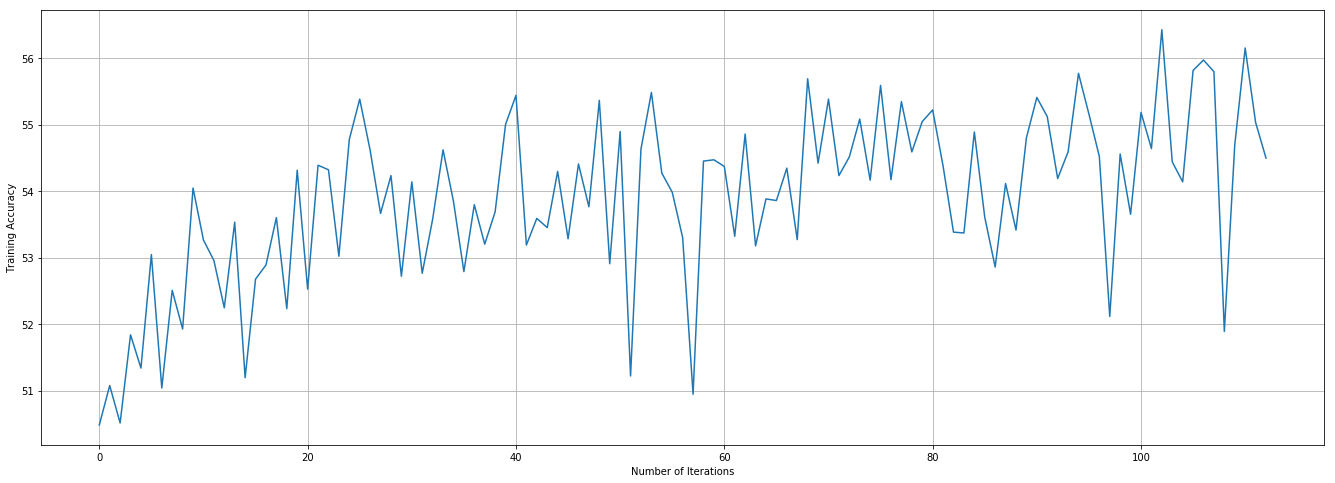

In [17]:
# The matplotlib package is used for plotting graphs
import matplotlib
import matplotlib.pyplot as plt 
# Outputs training accuracy and loss against epoch for the first random initialization only
fig2, ax2=plt.subplots(figsize=(23,8))
ax2.plot( training)
ax2.set(xlabel='Number of Iterations', ylabel='Training Accuracy')
ax2.grid()
plt.show()

# Neural Networks

In [18]:
processedTrainingLabel = np_utils.to_categorical(np.array(trainingTarget),2)
processedTestingLabel = np_utils.to_categorical(np.array(testingTarget),2)
processedTestingData = testingData
processedtrainingData = trainingData

In [19]:
# Defining Placeholder
inputTensor  = tf.placeholder(tf.float32, [None, len(trainingData[0])])
outputTensor = tf.placeholder(tf.float32, [None, 2])
testLabel    =tf.placeholder(tf.float32, [None, None])

In [20]:
# Defining number of neurons in each layer
NUM_HIDDEN_NEURONS_LAYER_1 = 100
NUM_HIDDEN_NEURONS_LAYER_2 = 100

# Defining the learning rate which will be used by the Optimizer to reach an optimal point or minima
LEARNING_RATE = 0.07

# Initializing the weights to Normal Distribution, this is done to increase the probability that the weights will achieve a good minima, and not get stuck at a bad minima
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.01))

# Initializing the input to hidden layer weights
input_hidden_weights_1  = init_weights([len(trainingData[0]), NUM_HIDDEN_NEURONS_LAYER_1])

# Initializing the hidden 1 to hidden 2 layer weights
input_hidden_weights_2  = init_weights([NUM_HIDDEN_NEURONS_LAYER_1, NUM_HIDDEN_NEURONS_LAYER_2])

# Initializing the hidden to output layer weights
hidden_output_weights = init_weights([NUM_HIDDEN_NEURONS_LAYER_2, 2])

# Computing values at the hidden layers using the relu activation function
hidden_layer_1 = tf.nn.relu(tf.matmul(inputTensor, input_hidden_weights_1))
tf.nn.dropout(hidden_layer_1,0.2)

hidden_layer_2 = tf.nn.relu(tf.matmul(hidden_layer_1, input_hidden_weights_2))

# Computing values at the output layer by matrix multiplication
output_layer = tf.matmul(hidden_layer_2, hidden_output_weights)

# Defining Error Function, here cross entropy loss function is used to minimise loss, along with softmax activation at the output layer
# Softmax ensures the probability of each class is obtained as the output of the network
error_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output_layer, labels=outputTensor))

# Defining Learning Algorithm and Training Parameters passed
training = tf.train.AdagradOptimizer(LEARNING_RATE).minimize(error_function)

# Prediction Function, gives class which the algorithm gives the max probability of being correct
prediction = tf.argmax(output_layer, 1)

# Class wise accuracy metric is defined, to get accuracy of prediction of each output class/ label
accuracy, accuracyOp = tf.metrics.mean_per_class_accuracy(labels=tf.argmax(testLabel,1),predictions=tf.argmax(output_layer,1), num_classes=4)

In [21]:
# Number of Epochs determine the number of times the algorithm is repeatedly trained on the training data
NUM_OF_EPOCHS = 1000

# Batch size determines the size of the input matrix that is given to the network to train at one go, and is usually kept between 50 and 256
BATCH_SIZE = 150

# Defining number of times the algorithm will be trained with different random weight initializations but same hyper-parameters and network settings, in order to get mean and variance of accuracies of the model
NUM_OF_INIT=1

# The same network setting will be used to collect data on accuracies, loss and predictions for different random weight initializations and the following lists are initialized to hold this data
training_accuracy_list = []
training_loss_list = []
predictedTestLabel=[]
accuracyList=[]
processedTrainingData = trainingData
# Starting tensorflow session
with tf.Session() as sess:

    # Run NUM_OF_INIT times to run over NUM_OF_INIT random weight initializations
    for itr in range (NUM_OF_INIT):
        training_accuracy = []
        training_loss = []

    
        # Sets values for the variables in the TensorFlow network
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run()

        # Ouputs the progress meter in the notebook
        for epoch in tqdm_notebook(range(NUM_OF_EPOCHS)):
        
            # Shuffles the Training Dataset at each epoch
            p = np.random.permutation(range(len(processedTrainingData)))
            processedTrainingData  = processedTrainingData[p]
            processedTrainingLabel = processedTrainingLabel[p]

            # Start batch training
            for start in range(0, len(processedTrainingData), BATCH_SIZE):
                end = start + BATCH_SIZE
                sess.run(training, feed_dict={inputTensor: processedTrainingData[start:end], 
                                              outputTensor: processedTrainingLabel[start:end]})
            # Training accuracy for an epoch
            training_accuracy.append(np.mean(np.argmax(processedTrainingLabel, axis=1) ==
                                 sess.run(prediction, feed_dict={inputTensor: processedTrainingData,
                                                                 outputTensor: processedTrainingLabel})))
            # Training loss for an epoch
            training_loss.append(sess.run(error_function, feed_dict={inputTensor: processedTrainingData,
                                                                 outputTensor: processedTrainingLabel}))
        # Collects training accuracies over each epoch for different weight initializations 
        training_accuracy_list.append(training_accuracy)
        training_loss_list.append(training_loss)
        # Testing: Collects predictions output by the network over the testing inpupt data
        predictedTestLabel.append(sess.run(prediction, feed_dict={inputTensor: processedTestingData}))
        # Gets the training accuracies of each class by comparing prediction and testing output labels
        accuracyList.append(sess.run(accuracyOp, feed_dict={inputTensor: processedTestingData, testLabel: processedTestingLabel}))

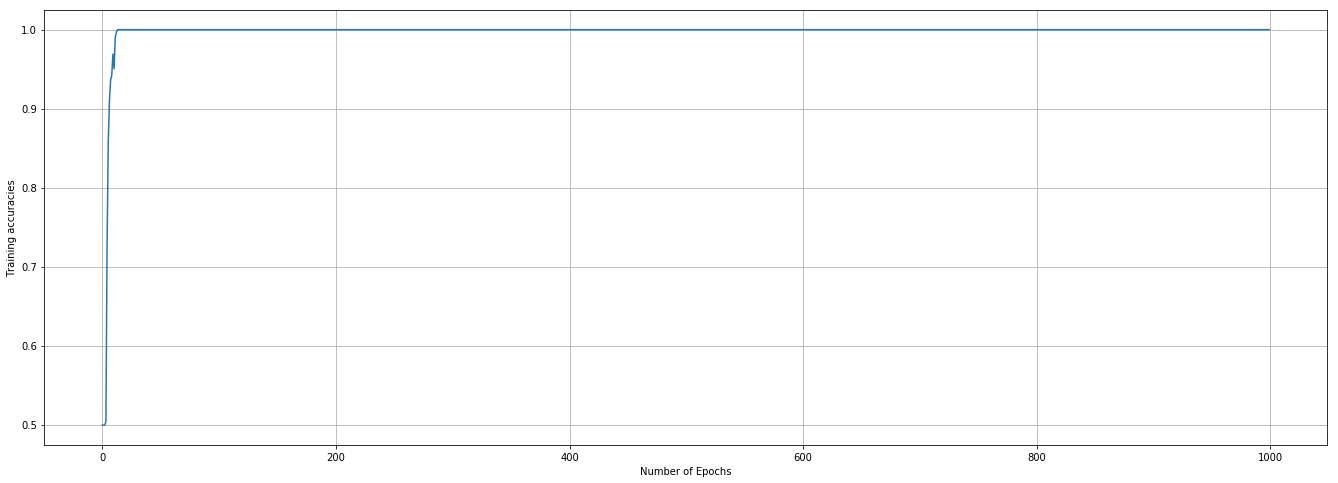

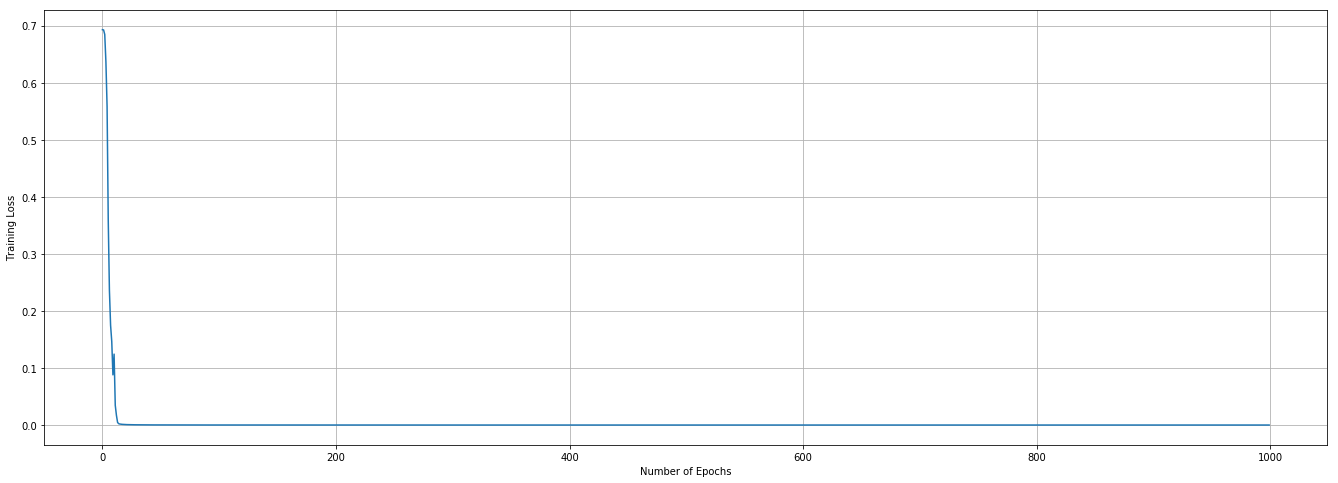

In [22]:
# The matplotlib package is used for plotting graphs
import matplotlib
import matplotlib.pyplot as plt 

# Outputs training accuracy and loss against epoch for the first random initialization only
fig1, ax1=plt.subplots(figsize=(23,8))
ax1.plot(np.array(training_accuracy_list[0]))
ax1.set(xlabel='Number of Epochs', ylabel='Training accuracies')
ax1.grid()
fig2, ax2=plt.subplots(figsize=(23,8))
ax2.plot( training_loss_list[0])
ax2.set(xlabel='Number of Epochs', ylabel='Training Loss')
ax2.grid()
plt.show()

In [23]:

predictedTestLabelListFin=[]
errors=[]
correct=[]
accuracy=[]
right=0
wrong=0
# Predictions of different weight initializations are looped over to be able to calculate accuracy for each random weight initialization
for i,j in zip(testingTarget,predictedTestLabel[0]):
        # 'others' class
#         print(8)
        # Counts the number of errors and correct predictions over the testing dataset
        if i == j:
            right = right + 1
        else:
            wrong = wrong + 1
print("Training Accuracy: " + str(training_accuracy_list[0][len(training_accuracy_list[0])-1]*100))
print("Testing Accuracy: " + str(right/(right+wrong)*100))
# Prints number of errors, and correct predictions for the random weight initialization that had the best  accuracy
print("Errors: " + str(wrong), " Correct :" + str(right)+'\n')

# print(training_accuracy_list)

Training Accuracy: 100.0
Testing Accuracy: 90.94547273636819
Errors: 181  Correct :1818

